In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
DATA_PATH = "./data/aligned_data/"

In [77]:
with open("./data/aligned_ticker_1878.json") as jsf:
    new_tickers = json.load(jsf)

In [78]:
prices = pd.read_csv(f"{DATA_PATH}/prices.csv", parse_dates=True, index_col=0)
returns = pd.read_csv(f"{DATA_PATH}/returns.csv", parse_dates=True, index_col=0)
volume = pd.read_csv(f"{DATA_PATH}/volume.csv", parse_dates=True, index_col=0)
ychopmdf = pd.read_csv(f"{DATA_PATH}/ychopmdf.csv", parse_dates=True, index_col=0) / 100
asset_turnover = pd.read_csv(f"{DATA_PATH}/asset_turnover.csv", parse_dates=True, index_col=0)
benchmark_prices = pd.read_csv(f"{DATA_PATH}/benchmark_sp500.csv", parse_dates=True, index_col=0)

company_info = pd.read_csv("./data/yf/company_info.csv")

In [79]:
benchmark = (1 + benchmark_prices.pct_change()).apply(np.log).iloc[1:]
benchmark.T

Date,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01,2021-04-01,2022-04-01,2023-04-01
adj_close,0.247869,0.030955,0.164849,0.199141,0.051153,0.01718,0.143781,0.114857,0.078976,0.052488,0.326538,-0.126887,0.085697


To compose portfolios with lowest Operating Margin and highest Asset Turnover we need a way to select best candidates. To this end, I will constuct a matrix with the difference of normalized Asset Turnover and Operating Margin.

In [80]:
def min_max_scale(df: pd.DataFrame) -> pd.DataFrame:
    df = (df - df.min()) / (df.max() - df.min())
    return df.copy()

In [81]:
asset_turnover.T.describe()

date,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01,2021-04-01,2022-04-01,2023-04-01
count,1305.000000,1370.000000,1439.000000,1429.000000,1435.000000,1432.000000,1418.000000,1426.000000,1435.000000,1428.000000,1431.000000,1406.000000,1422.000000
mean,1.010640,1.036952,1.019370,0.999019,0.982535,0.927663,0.906086,0.894694,0.899375,0.863448,0.775266,0.809848,0.886950
std,0.924548,0.937170,0.926441,0.922335,0.898722,0.812468,0.762356,0.750489,0.757387,0.719789,0.650543,0.694917,0.774880
min,0.012465,0.013403,-0.242140,0.011240,0.012108,0.009632,0.009705,0.011975,-0.055927,0.014530,0.006633,-1.900920,-0.785907
25%,0.458644,0.463316,0.457041,0.439247,0.444430,0.406542,0.408310,0.396130,0.396954,0.387464,0.350576,0.383198,0.415301
50%,0.795539,0.842319,0.809636,0.788305,0.763038,0.726132,0.725221,0.726637,0.727441,0.689295,0.624593,0.670920,0.725911
75%,1.275752,1.323878,1.312991,1.282075,1.250650,1.211298,1.198630,1.180717,1.197453,1.130541,1.002793,1.035381,1.122223
max,11.221488,11.055405,11.010551,11.414836,11.504301,11.203356,11.212121,10.510263,9.729531,9.352953,8.799283,8.883930,8.873837


<Axes: >

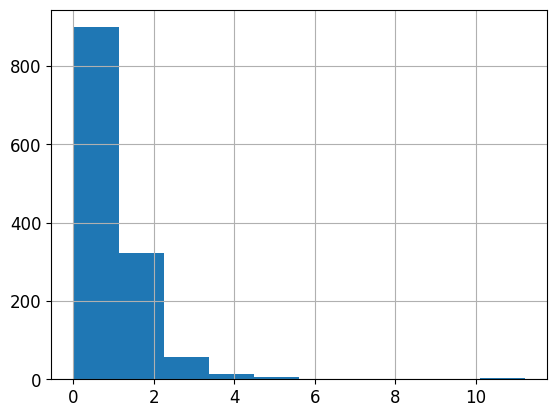

In [82]:
asset_turnover.T["2011-04-01"].hist()

In [83]:
asset_turnover.isna().sum().sort_values()

A        0
KMTUY    0
KMT      0
KMB      0
KLIC     0
        ..
PCTI     3
NLS      3
EHTH     3
AXON     3
LPX      3
Length: 1440, dtype: int64

In [84]:
diff_vector = (min_max_scale(asset_turnover.T) - min_max_scale(ychopmdf.T)).T

In [85]:
diff_vector.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2011-04-01 to 2023-04-01
Columns: 1440 entries, A to SEKEY
dtypes: float64(1440)
memory usage: 146.9 KB


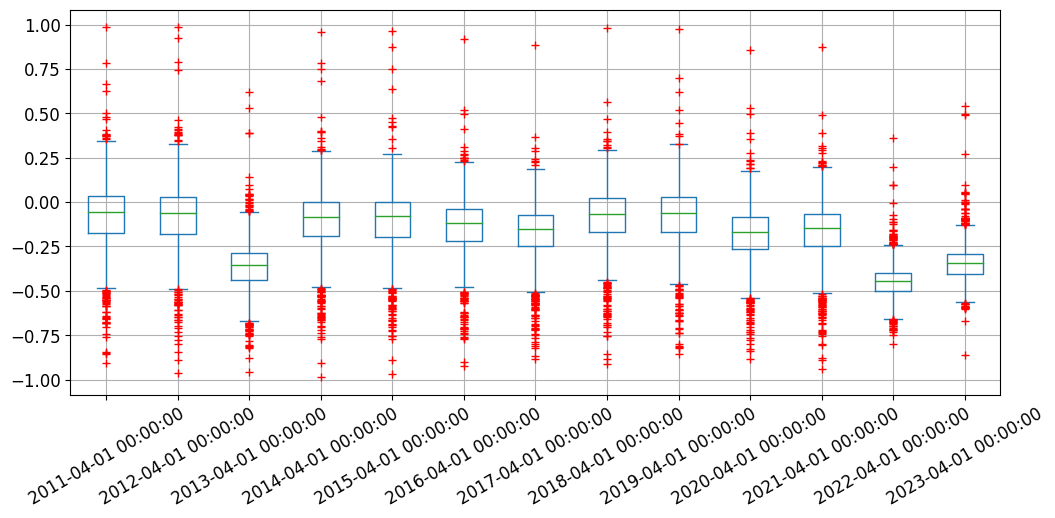

In [86]:
diff_vector.T.plot(kind="box", figsize=(12,5), rot=30, grid=True, sym="r+")
plt.show()

In [87]:
%autoreload 2
from strategies import PortfolioType, Universe, Portfolio, Strategy  # noqa: F401


In [88]:
universe = Universe(diff_vector, ychopmdf, asset_turnover, returns, volume, company_info)
strategy = Strategy()
strategy.construct_portfolios(universe, pd.DateOffset(years=1))

100%|██████████| 12/12 [00:00<00:00, 31.04it/s]


In [89]:
# strategy.portfolios['2011-04-01'][0].info

atest_df = pd.concat([port[0].info for port in strategy.portfolios.values()]) # type: ignore

In [90]:
loht_returns = []
holt_returns = []
difference = []

for loht, holt in strategy.portfolios.values():
    loht_returns.append(loht.mean_return)
    holt_returns.append(holt.mean_return)
    difference.append(loht.mean_return - holt.mean_return) # type: ignore

In [93]:
results_df = pd.DataFrame([loht_returns, holt_returns, benchmark.values.flatten()[:-1]])
results_df.columns = [date.strftime("%Y-%m-%d") for date in diff_vector.index[:-1]]
results_df = results_df.set_index(
    pd.Index(
        [
            "LOHT",
            "HOLT",
            "S&P 500 YoY Returns",
        ],
        name=None,
    )
)
results_df

,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01,2021-04-01,2022-04-01
LOHT,0.099557,0.380308,0.183221,-0.047747,-0.190003,0.130716,-0.189152,0.133979,-0.221649,0.439474,0.094658,0.046479
HOLT,-0.158522,-0.032006,0.120580,-0.238122,0.103756,0.092352,0.201687,0.176124,-0.362383,0.456257,-0.227851,-0.298668
S&P 500 YoY Returns,0.247869,0.030955,0.164849,0.199141,0.051153,0.017180,0.143781,0.114857,0.078976,0.052488,0.326538,-0.126887


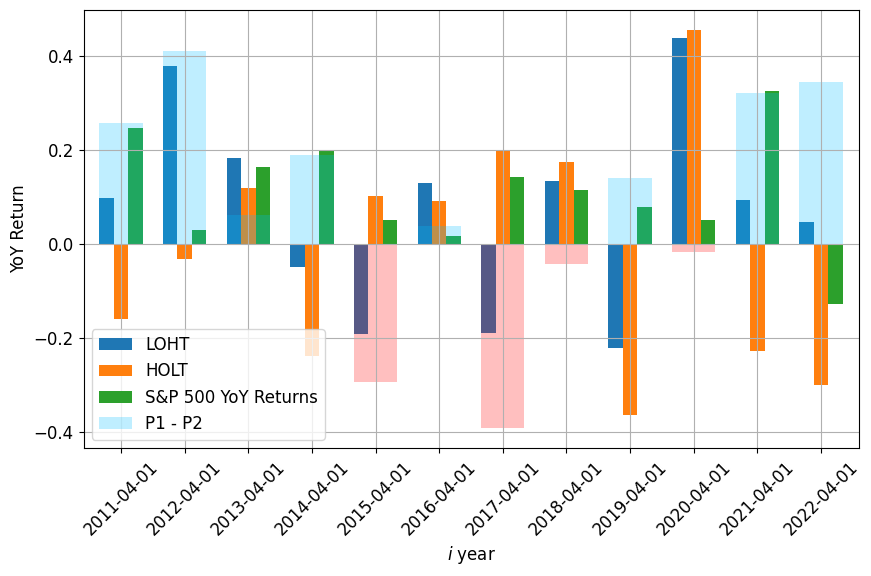

In [95]:
plt.rcParams["font.size"] = "12"

results_df.T.plot(
    kind="bar",
    figsize=(10, 6),
    xlabel=r"$i$ year",
    ylabel="YoY Return",
    width=0.68,
)

(results_df.iloc[0] - results_df.iloc[1]).plot(
    kind="bar",
    secondary_y=False,
    color=np.where((results_df.iloc[0] - results_df.iloc[1]) < 0, "red", "deepskyblue"),
    grid=True,
    label="P1 - P2",
    alpha=0.25,
    width=0.68,
)

plt.legend(loc="lower left")
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)